In [1]:
import datetime
import os

import tensorboard
import tensorflow as tf

import tensorflow.keras.applications.resnet

from smot.jupyter import model_reports
from smot.problems.mnist import mnist_lib

In [2]:
(x_train, y_train), (x_test, y_test) = mnist_lib.load_mnist_data_28x28x1()

In [3]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size=3):
        super(IdentityBlock, self).__init__(name="")

        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_size, padding="same"
        )
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
        )
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation("relu")
        self.add = tf.keras.layers.Add()

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x


class ResNetSmall(tf.keras.Model):
    def __init__(self, num_classes, *, input_shape):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(
            64, 7, input_shape=input_shape, padding="same"
        )
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation("relu")
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)


model = ResNetSmall(10, input_shape=mnist_lib.INPUT_SHAPE)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Print the model summary.
# model.summary()

Epoch 1/200
375/375 [==============================] - 7s 16ms/step - loss: 0.5947 - accuracy: 0.8398 - val_loss: 3.7091 - val_accuracy: 0.1623
Epoch 2/200
375/375 [==============================] - 6s 14ms/step - loss: 0.0817 - accuracy: 0.9783 - val_loss: 0.3999 - val_accuracy: 0.8674
Epoch 3/200
375/375 [==============================] - 6s 14ms/step - loss: 0.0612 - accuracy: 0.9818 - val_loss: 0.1347 - val_accuracy: 0.9576
Epoch 4/200
375/375 [==============================] - 6s 14ms/step - loss: 0.0475 - accuracy: 0.9859 - val_loss: 0.1114 - val_accuracy: 0.9658
Epoch 5/200
375/375 [==============================] - 6s 14ms/step - loss: 0.0431 - accuracy: 0.9878 - val_loss: 0.1197 - val_accuracy: 0.9626
Epoch 6/200
375/375 [==============================] - 6s 14ms/step - loss: 0.0394 - accuracy: 0.9883 - val_loss: 0.2862 - val_accuracy: 0.9213
Epoch 7/200
375/375 [==============================] - 6s 14ms/step - loss: 0.0337 - accuracy: 0.9899 - val_loss: 0.0715 - val_accuracy:

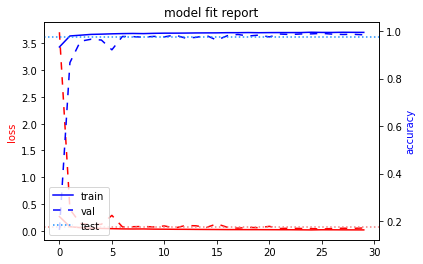

In [4]:
batch_size = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    validation_split=0.2,
)
datagen.fit(x_train)

training_generator = datagen.flow(
    x_train,
    y_train,
    subset="training",
    batch_size=batch_size,
)
validation_generator = datagen.flow(
    x_train,
    y_train,
    subset="validation",
    batch_size=batch_size,
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%load_ext tensorboard
%tensorboard --logdir logs


history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=200,
    verbose=1,
    use_multiprocessing=True,
    workers=24,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5),
        tensorboard_callback,
    ],
)

# Evaluate the model with the test data.
test_loss, test_accuracy = model_reports.model_fit_report(
    model=model,
    history=history,
    test_data=(x_test, y_test),
)